# Credit Risk Resampling Techniques

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

# Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('./Data/LoanStats_2019Q1.csv')
loans_df = pd.read_csv(file_path, skiprows=1)[:-2]
loans_df = loans_df.loc[:, columns].copy()

# Drop the columns where all values are null
loans_df = loans_df.dropna(axis='columns', how='all')

# Drop the null rows
loans_df = loans_df.dropna()

# Remove the 'Issued' loan status
issued_mask = loans_df['loan_status'] != 'Issued'
loans_df = loans_df.loc[issued_mask]

# Convert interest rate to numerical
loans_df['int_rate'] = loans_df['int_rate'].str.replace('%', '')
loans_df['int_rate'] = loans_df['int_rate'].astype('float') / 100

# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
loans_df = loans_df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
loans_df = loans_df.replace(x)

loans_df.reset_index(inplace=True, drop=True)

loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [5]:
# Filter for columns with categorical values
columns_obj = loans_df.select_dtypes(include='object').columns

In [7]:
# Examine counts of categorical columns
# If there is only one value, prepare to drop that column
droplist = []

for column in loans_df[columns_obj]:
    print(column, "\n", loans_df[column].value_counts())
    if len(loans_df[column].value_counts()) <= 1:
        droplist.append(column)

home_ownership 
 MORTGAGE    36219
RENT        24613
OWN          7346
ANY           639
Name: home_ownership, dtype: int64
verification_status 
 Not Verified       32895
Source Verified    25737
Verified           10185
Name: verification_status, dtype: int64
issue_d 
 Jan-2019    31041
Feb-2019    25579
Mar-2019    12197
Name: issue_d, dtype: int64
loan_status 
 low_risk     68470
high_risk      347
Name: loan_status, dtype: int64
pymnt_plan 
 n    68817
Name: pymnt_plan, dtype: int64
initial_list_status 
 w    60292
f     8525
Name: initial_list_status, dtype: int64
next_pymnt_d 
 May-2019    42449
Apr-2019    26368
Name: next_pymnt_d, dtype: int64
application_type 
 Individual    59206
Joint App      9611
Name: application_type, dtype: int64
hardship_flag 
 N    68817
Name: hardship_flag, dtype: int64
debt_settlement_flag 
 N    68817
Name: debt_settlement_flag, dtype: int64


In [8]:
# Drop columns with only one value
loans_df = loans_df.drop(columns=droplist)

In [9]:
# Save cleaned data
loans_df.to_csv("./Data/clean_loans.csv", index=False)

# Split the Data into Training and Testing

In [10]:
# loan_status is dependent variable; other columns are independent variables
# Create features
X = loans_df.drop(columns='loan_status')

# Create target
y = loans_df['loan_status']

In [11]:
# Check features
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,2.000000,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,3.000000,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,18.000000,19.000000,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06


In [12]:
# Transform object dtypes into int
X_encoded = pd.get_dummies(X)
X_encoded.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.148001,0.371696,0.451066,0.177238,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.355104,0.483261,0.497603,0.381873,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Check the balance of target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [14]:
# Scale data
data_scaler = StandardScaler()

X_encoded_scaled = data_scaler.fit_transform(X_encoded)

In [15]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y, random_state=1)

# Without Sampling

In [16]:
# Fit training data to a logistic curve
classifier = LogisticRegression(solver='lbfgs', random_state=1)

classifier.fit(X_train, y_train)

# Create predictions from test data
y_pred = classifier.predict(X_test)

In [17]:
# Calculate model accuracy
accuracy_score(y_test, y_pred)

0.995059575704737

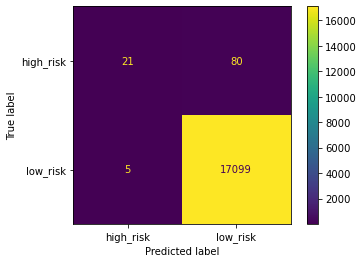

In [18]:
# Display confusion matrix
bl_matrix = confusion_matrix(y_test, y_pred)

bl_disp = ConfusionMatrixDisplay(confusion_matrix=bl_matrix,
            display_labels=classifier.classes_)
bl_disp.plot()
plt.savefig("./Images/bl_confusion_matrix.png")

In [19]:
# View imbalanced classification report
bl_report = classification_report_imbalanced(y_test, y_pred)
print(bl_report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.81      0.21      1.00      0.33      0.46      0.19       101
   low_risk       1.00      1.00      0.21      1.00      0.46      0.22     17104

avg / total       0.99      1.00      0.21      0.99      0.46      0.22     17205



# Oversampling

### Naive Random Oversampling

In [20]:
# Resample the training data with RandomOversampler
ros = RandomOverSampler(random_state=1)

X_ros, y_ros = ros.fit_resample(X_train, y_train)

# Check balance of resampled target values
Counter(y_ros)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [21]:
# Fit resampled data to a logistic curve
ros_classifier = LogisticRegression(solver='lbfgs', random_state=1)

ros_classifier.fit(X_ros, y_ros)

# Create predictions from test data
y_pred_ros = ros_classifier.predict(X_test)

In [22]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_ros)

0.8324883762931952

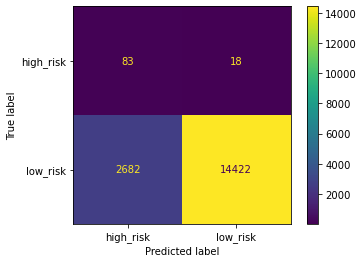

In [23]:
# Display confusion matrix
ros_matrix = confusion_matrix(y_test, y_pred_ros)

ros_disp = ConfusionMatrixDisplay(confusion_matrix=ros_matrix,
            display_labels=ros_classifier.classes_)
ros_disp.plot()
plt.savefig("./Images/ros_confusion_matrix.png")

In [24]:
# View imbalanced classification report
ros_report = classification_report_imbalanced(y_test, y_pred_ros)
print(ros_report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.82      0.84      0.06      0.83      0.69       101
   low_risk       1.00      0.84      0.82      0.91      0.83      0.69     17104

avg / total       0.99      0.84      0.82      0.91      0.83      0.69     17205



### SMOTE Oversampling

In [25]:
# Resample the training data with SMOTE
smote_ = SMOTE(random_state=1, sampling_strategy='auto')

X_smote, y_smote = smote_.fit_resample(X_train, y_train)

# Check balance of resampled target values
Counter(y_smote)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [26]:
# Fit resampled data to a logistic curve
smote_classifier = LogisticRegression(solver='lbfgs', random_state=1)

smote_classifier.fit(X_smote, y_smote)

# Create predictions from test data
y_pred_smote = smote_classifier.predict(X_test)

In [27]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_smote)

0.8440938486973113

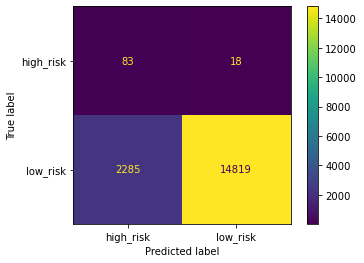

In [37]:
# Display confusion matrix
smote_matrix = confusion_matrix(y_test, y_pred_smote)

smote_disp = ConfusionMatrixDisplay(confusion_matrix=smote_matrix,
                display_labels=smote_classifier.classes_)
smote_disp.plot()
plt.savefig("./Images/sm_confusion_matrix.png")

In [29]:
# View imbalanced classification report
smote_report = classification_report_imbalanced(y_test, y_pred_smote)
print(smote_report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.82      0.87      0.07      0.84      0.71       101
   low_risk       1.00      0.87      0.82      0.93      0.84      0.72     17104

avg / total       0.99      0.87      0.82      0.92      0.84      0.72     17205



# Undersampling

In [30]:
# Resample the data using ClusterCentroids
cc = ClusterCentroids(random_state=1)

X_cc, y_cc = cc.fit_resample(X_train, y_train)

# Check balance of resampled target values
Counter(y_cc)

Counter({'high_risk': 246, 'low_risk': 246})

In [31]:
# Fit resampled data to a logistic curve
cc_classifier = LogisticRegression(solver='lbfgs', random_state=1)

cc_classifier.fit(X_cc, y_cc)

# Create predictions from test data
y_pred_cc = cc_classifier.predict(X_test)

In [32]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_cc)

0.8203882595930314

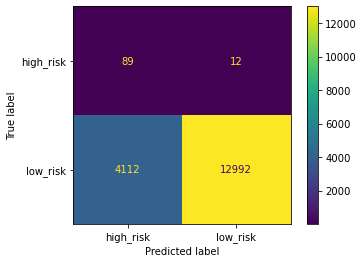

In [34]:
# Display confusion matrix
cc_matrix = confusion_matrix(y_test, y_pred_cc)

cc_disp = ConfusionMatrixDisplay(confusion_matrix=cc_matrix,
                display_labels=cc_classifier.classes_)
cc_disp.plot()
plt.savefig("./Images/cc_confusion_matrix.png")

In [43]:
# View imbalanced classification report
cc_report = classification_report_imbalanced(y_test, y_pred_cc)
print(cc_report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.88      0.76      0.04      0.82      0.68       101
   low_risk       1.00      0.76      0.88      0.86      0.82      0.66     17104

avg / total       0.99      0.76      0.88      0.86      0.82      0.66     17205



# Combination (Over and Under) Sampling

In [36]:
# Resample the training data with SMOTEENN
smoteenn_ = SMOTEENN(random_state=1)

X_smoteenn, y_smoteenn = smoteenn_.fit_resample(X_train, y_train)

# Check balance of resampled target values
Counter(y_smoteenn)

Counter({'high_risk': 51366, 'low_risk': 47640})

In [38]:
# Fit resampled data to a logistic curve
smoteenn_classifier = LogisticRegression(solver='lbfgs', random_state=1)

smoteenn_classifier.fit(X_smoteenn, y_smoteenn)

# Create predictions from test data
y_pred_smoteenn = smoteenn_classifier.predict(X_test)

In [39]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_smoteenn)

0.8389196204466096

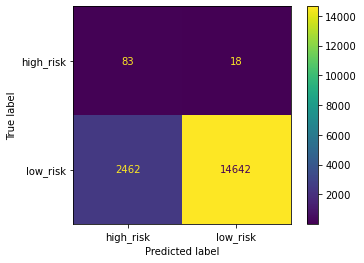

In [40]:
# Display confusion matrix
smoteenn_matrix = confusion_matrix(y_test, y_pred_smoteenn)

smoteenn_disp = ConfusionMatrixDisplay(confusion_matrix=smoteenn_matrix,
                display_labels=smoteenn_classifier.classes_)
smoteenn_disp.plot()
plt.savefig("./Images/smtn_confusion_matrix.png")

In [41]:
# View imbalanced classification report
smoteenn_report = classification_report_imbalanced(y_test, y_pred_smoteenn)
print(smoteenn_report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.82      0.86      0.06      0.84      0.70       101
   low_risk       1.00      0.86      0.82      0.92      0.84      0.71     17104

avg / total       0.99      0.86      0.82      0.92      0.84      0.71     17205

